In [2]:
import numpy as np
import pickle

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from qkeras.utils import model_save_quantized_weights

from tf_data_pipeline.data import WaveToWaveData
from qkeras_version.qkeras_model import create_dilated_model, masked_mse

from fxpmath_version.fxpmath_model import FxpModel

2023-10-09 15:02:36.799733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## train qkeras model

In [6]:
class Opts(object):
    learning_rate = 1e-3
    num_train_egs = 20000
    num_validate_egs = 100
    num_test_egs = 100
    epochs = 5
    
opts = Opts()


In [7]:
IN_OUT_D = 4
NUM_LAYERS = 3
# WIP filter size; final will be 8
FILTER_SIZE = 4

# note: kernel size and implied dilation rate always assumed 4

RECEPTIVE_FIELD_SIZE = 4**NUM_LAYERS
TEST_SEQ_LEN = RECEPTIVE_FIELD_SIZE
TRAIN_SEQ_LEN = RECEPTIVE_FIELD_SIZE * 5
print("RECEPTIVE_FIELD_SIZE", RECEPTIVE_FIELD_SIZE)
print("TRAIN_SEQ_LEN", TRAIN_SEQ_LEN)
print("TEST_SEQ_LEN", TEST_SEQ_LEN)

RECEPTIVE_FIELD_SIZE 64
TRAIN_SEQ_LEN 320
TEST_SEQ_LEN 64


In [8]:
# make tf datasets

# recall WaveToWaveData
# x -> (tri,0,0,0)
# y -> (tri,square,zigzag,0)

data = WaveToWaveData()

train_ds = data.tf_dataset_for_split('train', TRAIN_SEQ_LEN, opts.num_train_egs)
validate_ds = data.tf_dataset_for_split('validate', TRAIN_SEQ_LEN, opts.num_validate_egs)

In [5]:
# make model
train_model = create_dilated_model(TRAIN_SEQ_LEN,
        in_out_d=IN_OUT_D, num_layers=NUM_LAYERS, filter_size=FILTER_SIZE,
        all_outputs=False)
print(train_model.summary())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 4)]          0         
                                                                 
 qconv_0 (QConv1D)           (None, 320, 4)            68        
                                                                 
 qrelu_0 (QActivation)       (None, 320, 4)            0         
                                                                 
 qconv_1 (QConv1D)           (None, 320, 4)            68        
                                                                 
 qrelu_1 (QActivation)       (None, 320, 4)            0         
                                                          

In [6]:
# compile loss that only considers column 1 of output ( i.e. square wave )
train_model.compile(Adam(opts.learning_rate),
                    loss=masked_mse(RECEPTIVE_FIELD_SIZE, filter_column_idx=1))

In [7]:
train_model.fit(train_ds,
                validation_data=validate_ds,
                epochs=20)

Epoch 1/20
157/157 [==============================] - 6s 12ms/step - loss: 0.2873 - val_loss: 0.1079
Epoch 2/20
157/157 [==============================] - 2s 8ms/step - loss: 0.1016 - val_loss: 0.0904
Epoch 3/20
157/157 [==============================] - 1s 7ms/step - loss: 0.0855 - val_loss: 0.0744
Epoch 4/20
157/157 [==============================] - 2s 7ms/step - loss: 0.0695 - val_loss: 0.0626
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0597 - val_loss: 0.0552
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0533 - val_loss: 0.0504
Epoch 7/20
157/157 [==============================] - 1s 7ms/step - loss: 0.0484 - val_loss: 0.0463
Epoch 8/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0444 - val_loss: 0.0426
Epoch 9/20
157/157 [==============================] - 2s 9ms/step - loss: 0.0412 - val_loss: 0.0399
Epoch 10/20
157/157 [==============================] - 2s 7ms/step - loss: 0.0386 - val_loss: 0.037

In [11]:
weights = model_save_quantized_weights(train_model)
from qkeras.utils import model_save_quantized_weights
with open('qkeras_weights.pkl', 'wb') as f:
    pickle.dump(model_save_quantized_weights(train_model),
                f, protocol=pickle.HIGHEST_PROTOCOL)

... quantizing model
... quantizing model


In [3]:
with open('qkeras_weights.pkl', 'rb') as f:
    weights = pickle.load(f)

In [4]:
weights

{'qconv_0': {'weights': [array([[[-0.1743164 , -0.18017578,  0.09228516,  0.578125  ],
           [ 0.11962891, -0.4140625 ,  0.19580078, -0.2529297 ],
           [ 0.3095703 , -0.00537109,  0.5385742 ,  0.1274414 ],
           [-0.20507812,  0.00195312, -0.13623047, -0.6899414 ]],
   
          [[-0.57177734, -0.37451172,  0.45751953, -0.7055664 ],
           [ 0.1015625 , -0.55908203, -0.30371094,  0.03320312],
           [ 0.13134766, -0.08642578, -0.48046875,  0.45654297],
           [ 0.5678711 ,  0.19335938, -0.09619141,  0.04980469]],
   
          [[-0.00244141,  0.19580078,  0.6621094 , -0.30371094],
           [-0.01953125, -0.3725586 , -0.45214844,  0.4482422 ],
           [-0.10009766, -0.24853516, -0.12353516,  0.43847656],
           [ 0.        , -0.06005859, -0.25683594, -0.16259766]],
   
          [[-0.89404297,  1.0566406 ,  0.7602539 , -0.62353516],
           [-0.70947266, -0.25732422,  0.5776367 , -0.54052734],
           [ 0.37646484,  0.16210938,  0.15283203,  0

## load weights into fxp model

In [9]:

# make model
inference_model = create_dilated_model(TEST_SEQ_LEN,
        in_out_d=IN_OUT_D, num_layers=NUM_LAYERS, filter_size=FILTER_SIZE,
        all_outputs=False)
inference_model.set_weights(train_model.get_weights())
print(inference_model.summary())


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


NameError: name 'train_model' is not defined

In [11]:
# make a dataset from test with x5 the test sequence length to run through 

test_ds = data.tf_dataset_for_split('test', TEST_SEQ_LEN*5, opts.num_test_egs)

for x, y in test_ds:
    break

x, y = x[0], y[0]
x.shape, y.shape

(TensorShape([320, 4]), TensorShape([320, 4]))

## just run from weights

In [1]:
from fxpmath_version.fxpmath_model import FxpModel
import numpy as np

fxp_model = FxpModel('qkeras_weights.pkl')

fxp_model.qconv0.export_weights_per_dot_product("/tmp/qconv0_weights")

>RollingCache depth=4 dilation=4 kernel_size=4 => num_entries=16
>RollingCache depth=4 dilation=16 kernel_size=4 => num_entries=64


In [6]:
# x = np.array([[0, 0.5,  0.25, 0.125],
#               [0, -0.5,  -0.25, -0.125],
#               [0, 0.5,  0.25, 0.125],
#               [0, -0.5,  -0.25, -0.125]])

x = np.array([[0.25, -0.1259765625, 0.31396484375, -1],
              [0.25, -0.1259765625, 0.31396484375, -1],
              [0.25, -0.1259765625, 0.31396484375, -1],
              [0.25, -0.1259765625, 0.31396484375, -1]])

fxp_model.qconv0.apply(x, relu=False)

>row_by_matrix_multiply column=0
dp 0.25 -0.17431640625
dp -0.1259765625 0.11962890625
dp 0.31396484375 0.3095703125
dp -1.0 -0.205078125
>row_by_matrix_multiply column=1
dp 0.25 -0.18017578125
dp -0.1259765625 -0.4140625
dp 0.31396484375 -0.00537109375
dp -1.0 0.001953125
>row_by_matrix_multiply column=2
dp 0.25 0.09228515625
dp -0.1259765625 0.19580078125
dp 0.31396484375 0.53857421875
dp -1.0 -0.13623046875
>row_by_matrix_multiply column=3
dp 0.25 0.578125
dp -0.1259765625 -0.2529296875
dp 0.31396484375 0.12744140625
dp -1.0 -0.68994140625
< x0 w0 -> accum0= [fxp-s32/24(0.2436227798461914), fxp-s32/24(0.0034787654876708984), fxp-s32/24(0.3037288188934326), fxp-s32/24(0.9063479900360107)]
... ['00000000.001111100101111000010000', '00000000.000000001110001111111100', '00000000.010011011100000100101100', '00000000.111010000000011001101100']
x1 w1
>row_by_matrix_multiply column=0
dp 0.25 -0.57177734375
dp -0.1259765625 0.1015625
dp 0.31396484375 0.13134765625
dp -1.0 0.56787109375
>row_

array([-0.09399414, -0.55688477,  0.19677734,  0.89868164])

In [ ]:

results = []
for i in range(len(x)):
    if i%50 == 0: print(i, "/", len(x))
    results.append(fxp_model.predict(x[i]))

results = np.stack(results)

In [10]:
0.25+0.125

0.375

In [ ]:

# a0=1, a1=a2=a3=0

# 
# veri [00000000.000011001100000000000000,  11111111.011001110000000000000000,  00000000.101100001100000000000000,  111111111.10000110100000000000000]
# fxp  [00000000.000011001100000000000000', 11111111.011001110000000000000000', 00000000.101100001100000000000000', '11111111.110000110100000000000000']
# after bias add...
# veri [00000000.011100010110000000000000,  11111111.010100010010000000000000, 00000000.001100000110000000000000, 11111111.001111011010000000000000]
# fxp  [00000000.011100010110000000000000', 11111111.010100010010000000000000, 00000000.001100000110000000000000, 11111111.001111011010000000000000']
# LGTM !

# a0=a1=1, a2=a3=0

# after bias add
# veri [00000000.101011000000000000000000, 11111110.011111011000000000000000, 11111111.110001000010000000000000, 11111111.000100110010000000000000]
# fxp  [00000000.101011000000000000000000, 11111110.011111011000000000000000, 11111111.110001000010000000000000, 11111111.000100110010000000000000']
# LGTM !

# a0=a1=a2=a3 = 1

# after bias add
# veri  [11111111.010100110110000000000000, 11111111.100111111000000000000000, 00000001.011001010100000000000000, 11111110.010110010100000000000000]
# fxp   [11111111.010100110110000000000000, 11111111.100111111000000000000000, 00000001.011001010100000000000000, 11111110.010110010100000000000000']
# LGTM

# a0=a1=a2=a3 = -1
# veri  [00000001.011101011110000000000000, 00000000.001101001100000000000000, 11111101.100110100000000000000000, 00000000.100110111000000000000000]
# fxp   [00000001.011101011110000000000000, 00000000.001101001100000000000000, 11111101.100110100000000000000000, 00000000.100110111000000000000000']
# LGTM

#     dut.a0.value = [
#        0x0400,   # 0000.010000000000 0.25
#        0xFDFC,   # 1111.110111111100 -0.1259765625
#        0x0506,   # 0000.010100000110 0.31396484375
#        0xF000    # 1111.000000000000 -1.0
# a0=a1=a2=a3

# veri [11111111.111001111110011101011100, 11111111.011100010110011101111100, 00000000.001100100110110101000100, 00000000.111001100001010110000000]
# fxp  [11111111.111001111110011101011100, 11111111.011100010110011101111100, 00000000.001100100110110101000100, 00000000.111001100001010110000000']

/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mat/miniconda3/envs/cdcc/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

<Axes: xlabel='n', ylabel='value'>

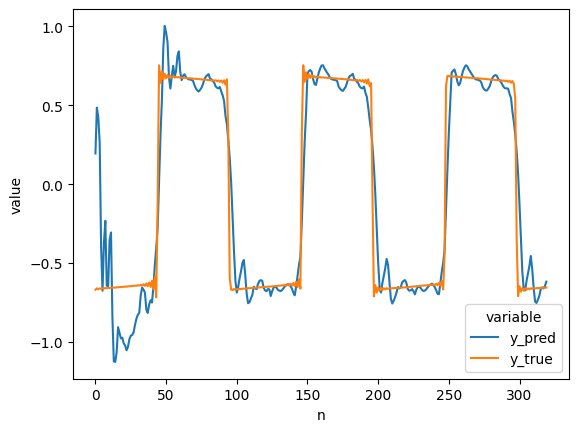

In [28]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame()

df['y_pred'] = results[:,1]     # recall; loss only covered element1 
df['y_true'] = y[:,1].numpy()
df['n'] = range(len(results))

wide_df = pd.melt(df, id_vars=['n'], value_vars=['y_pred', 'y_true'])
wide_df.head()

sns.lineplot(wide_df, x='n', y='value', hue='variable')

In [11]:
y[:,1].numpy().shape

(640,)